In [1]:
! rm -r unilm  
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git   
! cd unilm/layoutlm             
! pip install unilm/layoutlm   
! rm -r transformers         
! git clone https://github.com/huggingface/transformers.git 
! cd transformers 
! pip install ./transformers 
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip 
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX 
! sudo apt install tesseract-ocr 
! pip install pytesseract 

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 797, done.
remote: Total 797 (delta 0), reused 0 (delta 0), pack-reused 797
Receiving objects: 100% (797/797), 439.18 KiB | 11.87 MiB/s, done.
Resolving deltas: 100% (441/441), done.
Processing ./unilm/layoutlm
     |████████████████████████████████| 645kB 7.3MB/s 
     |████████████████████████████████| 204kB 40.1MB/s 
     |████████████████████████████████| 5.5MB 34.1MB/s 
     |████████████████████████████████| 1.2MB 44.7MB/s 
     |████████████████████████████████| 5.6MB 47.7MB/s 
     |████████████████████████████████| 901kB 49.3MB/s 
  Created wheel for layoutlm: filename=layoutlm-0.0-cp37-none-any.whl size=11486 sha256=37425efd7a7e1b51a84f2d5518f623909cba00f49db0fe442a25eff65dd60dbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-gkw7_2am/wheels/e8/9a/90/87de19930fb582e6176ea7912010f101efa37def32b8ced268
  Created wheel for seqeval: filename=seqeval-0.0.12-cp37-none-any.wh

In [2]:
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import random
import cv2 
from PIL import Image, ImageDraw, ImageFont 
from glob import glob
import time
import copy
import os
from scipy import misc
import shutil
from google.colab import drive
import sys
from tqdm import tqdm

from torch.nn import CrossEntropyLoss
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import vgg19, vgg19_bn
from torch.optim import lr_scheduler
from torchsummary import summary
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import LayoutLMForTokenClassification
from transformers import AdamW

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # setting the device 
drive.mount('/content/drive',force_remount=True) 
os.chdir('/content/drive/My Drive') 

Mounted at /content/drive


**LayoutLM**

In [4]:
num_labels =13
args = {'local_rank': -1,
        'overwrite_cache': True, 
        'data_dir': 'data', 
        'model_name_or_path':'microsoft/layoutlm-base-uncased', 
        'max_seq_length': 512, 
        'model_type': 'layoutlm',} 

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

In [5]:
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [6]:
save_path = '/content/drive/My Drive/Abinbev/' # change this as well if you run from colab
model.load_state_dict(torch.load(save_path+'layoutlm,5.pkl')) ### Change the path to where you have the weights 

<All keys matched successfully>

In [7]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size 

      tokens = [] 
      token_boxes = [] 
      actual_bboxes = [] # we use an extra b because actual_boxes is already used 
      token_actual_boxes = [] 
      for word, box, actual_bbox in zip(words, boxes, actual_boxes): 
          word_tokens = tokenizer.tokenize(word) 
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [8]:
def inference(image,words,boxes,actual_boxes,tokenizer,args):
  input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)
  input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
  attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
  token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
  bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
  outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
  token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

  word_level_predictions = [] # let's turn them into word level predictions
  final_boxes = []
  corresponding_words = []
  for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
    if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                            tokenizer.sep_token_id, 
                                                            tokenizer.pad_token_id]):
      # skip prediction + bounding box
      continue
    else:
      word_level_predictions.append(token_pred)
      final_boxes.append(box)

  return final_boxes, word_level_predictions

In [9]:
def text_from_crop(image,bl,tr,w,h):
  pad = 4 #  add some pixels around cluster area
  #img[ clamp(bottom_left[1] - pad,0,h) :clamp(top_right[1] + pad,0,h) , clamp(bottom_left[0] - pad,0,w):clamp(top_right[0] + pad,0,w), :]
  #img_crop = img[clamp(bl[1] - pad,1,h-1):clamp(tr[1] + pad,1,h-1),clamp(bl[0] - pad,1,w-1):clamp(tr[0] + pad,1,w-1), :]
  
    # The cropped image can have weird shape and tesseract OCR is more accurate if we transform the cropped image as followed
  img_crop=img[ bl[1] - pad :tr[1] + pad , bl[0] - pad:tr[0] + pad, :] 
  img_crop = cv2.resize(img_crop, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
  img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    # Run tesseract on the cropped image
  text = pytesseract.image_to_string(img_crop)
  return text

In [10]:
label_map={0: 'B-ANSWER',
 1: 'B-HEADER',
 2: 'B-QUESTION',
 3: 'E-ANSWER',
 4: 'E-HEADER',
 5: 'E-QUESTION',
 6: 'I-ANSWER',
 7: 'I-HEADER',
 8: 'I-QUESTION',
 9: 'O',
 10: 'S-ANSWER',
 11: 'S-HEADER',
 12: 'S-QUESTION'}

In [11]:
image = Image.open('page0.jpg') 
img = cv2.imread('page0.jpg') 
ocr_out = pytesseract.image_to_boxes(image) 
h, w, _ = img.shape 

points = []
for bbox in ocr_out.split('\n'):
    split = bbox.split(' ')
    text = split[0]
    try:
      point1 = (int(split[3]) + int(split[1])) / 2
      point2 =  (h -  int(split[4]) + h - int(split[2]))/2
      points.append([point1,point2])
    except: 
      pass

In [12]:
clustering = DBSCAN(eps=29, min_samples=2).fit_predict(points)

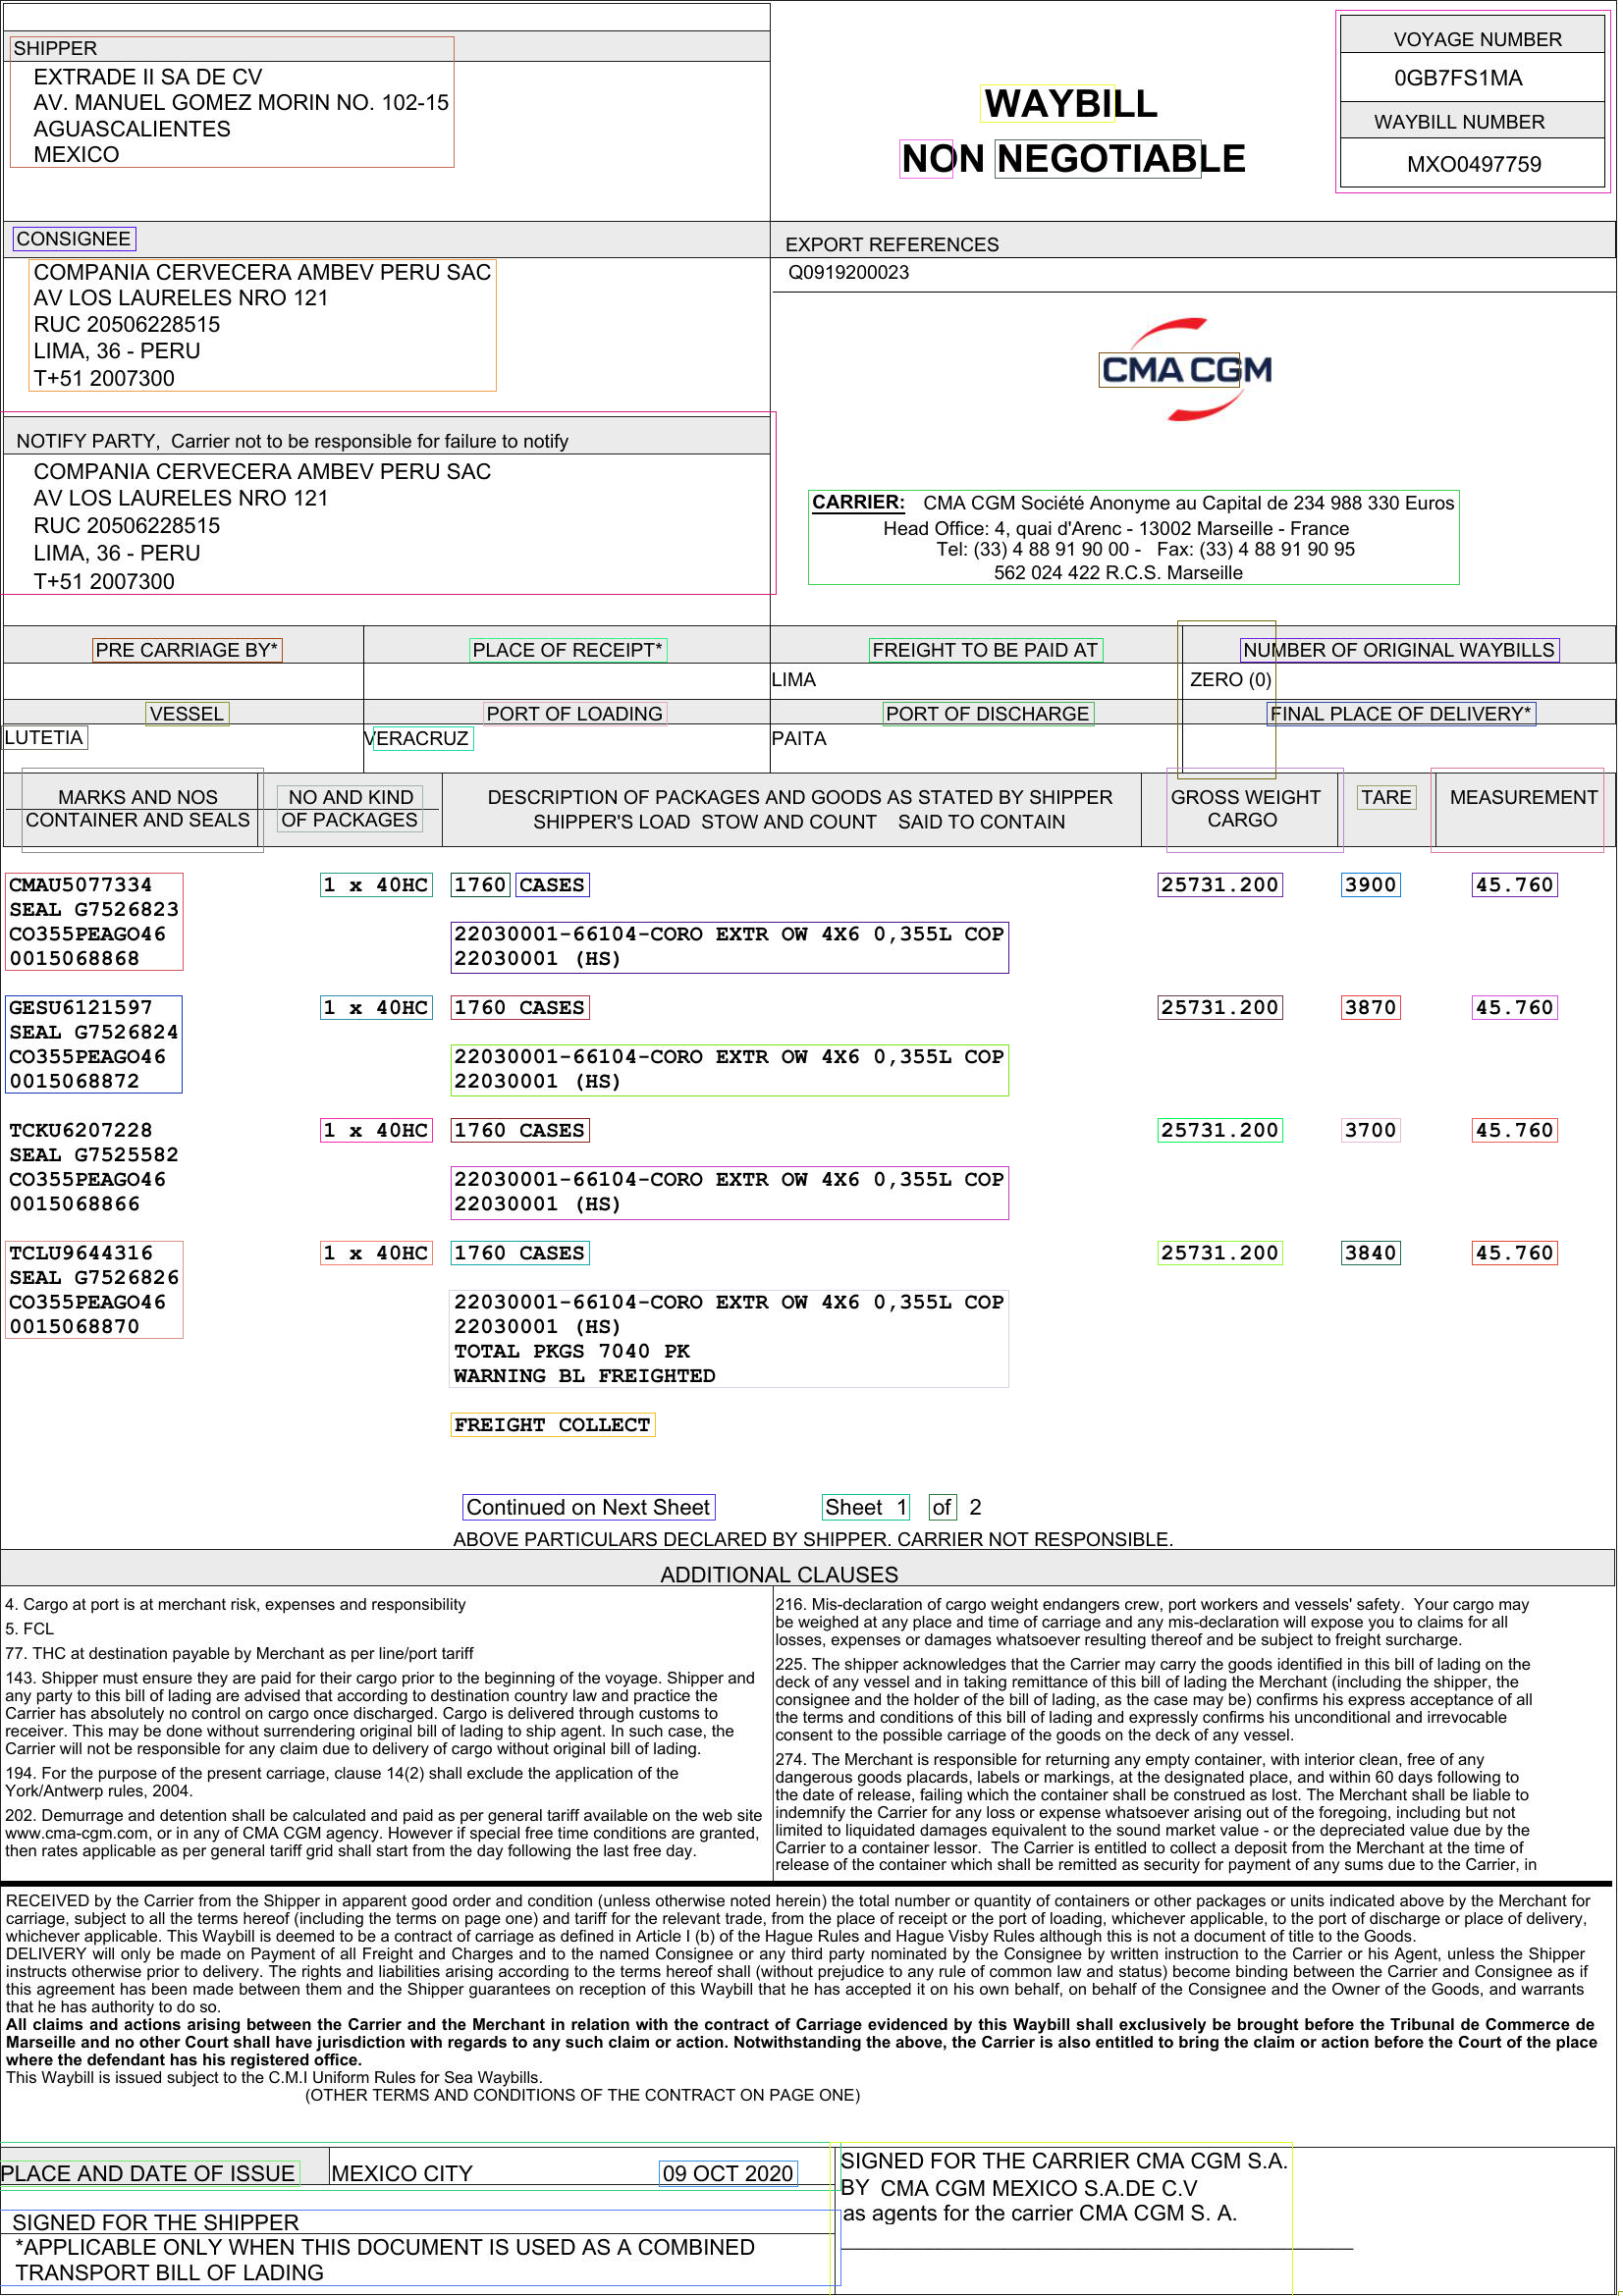

<Figure size 864x1152 with 0 Axes>

In [13]:
# Just for nice plotting: get a color for each cluster 
dico_color = {}
for i in range(np.max(clustering)+1):
    dico_color[i] = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
# Plot clusters

plt.figure(figsize=(12,16))
#img = cv2.imread('test.png')
img = cv2.imread('page0.jpg')
h, w, _ = img.shape

image = Image.open("page0.jpg")
#image = Image.open("test.png")
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

"""
# plot a rectangle around each character with the color of the cluster
for en,bbox in enumerate(ocr_out.split('\n')):
    split = bbox.split(' ')
    text = split[0]
    try:
      bottom_left = (int(split[1]), h - int(split[2]))
      top_right = (int(split[3]), h -  int(split[4]))
      if clustering[en] != -1:
          img = cv2.rectangle(img, bottom_left, top_right, dico_color[clustering[en]], 2)
    except:
      pass

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
"""

#  plot a rectangle around each cluster 
#img = cv2.imread('test.png')
dico_area_location = {} #  store location of each cluster for the following
for i in range(np.max(clustering)+1):
    wh = np.where(clustering==i) #  select points from cluster i
    arr = np.array(ocr_out.split('\n'))[wh]
    LX,LY = [], []
    for en,bbox in enumerate(arr):
        split = bbox.split(' ')       
        LX.append(int(split[1]))
        LX.append(int(split[3]))   
        LY.append( h - int(split[2]))
        LY.append( h - int(split[4]))
    if w-20<=(max(LX)-min(LX))<=w+20 or h-20<=(max(LY)-min(LY))<=h+20 :
      pass
    else:
      
      bottom_left = (min(LX)-5,min(LY)-5) # among every character in the cluster, take min(x), min(y) 
      top_right = (max(LX)+5,max(LY)+5) # among every character in the cluster, take max(x), max(y) 
      """ 
      bottom_left = (min(LX),min(LY))  
      top_right = (max(LX),max(LY)) 
      """ 
      dico_area_location[i] = [bottom_left, top_right]

      # img = cv2.rectangle(img, bottom_left, top_right, dico_color[i], 2) # draw a rectangle containing 
      draw.rectangle((bottom_left,top_right), outline=dico_color[i])
    # every character in the cluster  

#plt.subplot(1,2,2)
#plt.imshow(img)
#plt.axis('off')
#plt.show()
image

In [14]:
to_pop_list = []
words = []
coordinates=[]
corresponding = []

for cluster in dico_area_location: 
    [bottom_left, top_right] = dico_area_location[cluster] 
    pad = 4 #  add some pixels around cluster area 
    img_crop = img[ bottom_left[1] - pad :top_right[1] + pad, bottom_left[0] - pad:top_right[0] + pad , :]
    #img_crop = img[clamp(bottom_left[1] - pad,0,h-1) :clamp(top_right[1] + pad,0,h-1) , clamp(bottom_left[0] - pad,0,w-1):clamp(top_right[0] + pad,0,w-1), :]
    # The cropped image can have weird shape and tesseract OCR is more accurate if we transform the cropped image as followed


    #print(img_crop.shape)
    #print(img_crop.shape[1])
    if img_crop.shape[1]!=0:

      img_crop = cv2.resize(img_crop, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
      img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)

        # Run tesseract on the cropped image
      text = pytesseract.image_to_string(img_crop)
      if text != '': 
        words.append(text)
        bl = list(bottom_left)
        tr = list(top_right)
        bl.append(tr[0])
        bl.append(tr[1])
        coordinates.append(bl)
        dico_area_location[cluster].append(text)
        corresponding.append([text,bl])
      else:
        to_pop_list.append(cluster)

        
# Remove area without text        
for i in to_pop_list:
    dico_area_location.pop(i)

# Ensure no key is skipped due to removal
dico_area_location_copy = {}
for en, key in enumerate(dico_area_location):
    dico_area_location_copy[en] = dico_area_location[key]
dico_area_location = dico_area_location_copy 

In [15]:
actual_boxes = []
box_text = []
for box in coordinates:
  #x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  #actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
  actual_boxes.append(box)

width, height = image.size

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []

for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))

In [16]:
final_boxes, word_level_predictions = inference(image,words,boxes,actual_boxes,tokenizer,args)

In [17]:
width, height = image.size
w_scale = 1000/width 
h_scale = 1000/height 
#image = Image.open('test.png') 
image = Image.open('page0.jpg') 
ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \

#image_to_boxes

ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)


not_clustered_words = list(ocr_df.text)
not_clustered_coordinates = ocr_df[['left', 'top', 'width', 'height']]
text_df = ocr_df[['text']]
not_clustered_actual_boxes = []
nc_box_text = []
all_texts={}
for idx, row in not_clustered_coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  not_clustered_actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  not_clustered_actual_boxes.append(not_clustered_actual_box)
  nc_box_text.append(not_clustered_words[idx])
  all_texts[(x, y, x+w, y+h)] = list(text_df[idx:idx+1].text)[0] ## coordinates are keys in tuple form

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

not_clustered_boxes=[]
for box in not_clustered_actual_boxes:
  not_clustered_boxes.append(normalize_box(box, width, height))
#boxes

In [18]:
nc_final_boxes, nc_word_level_predictions = inference(image,not_clustered_words,not_clustered_boxes,not_clustered_actual_boxes,tokenizer,args)

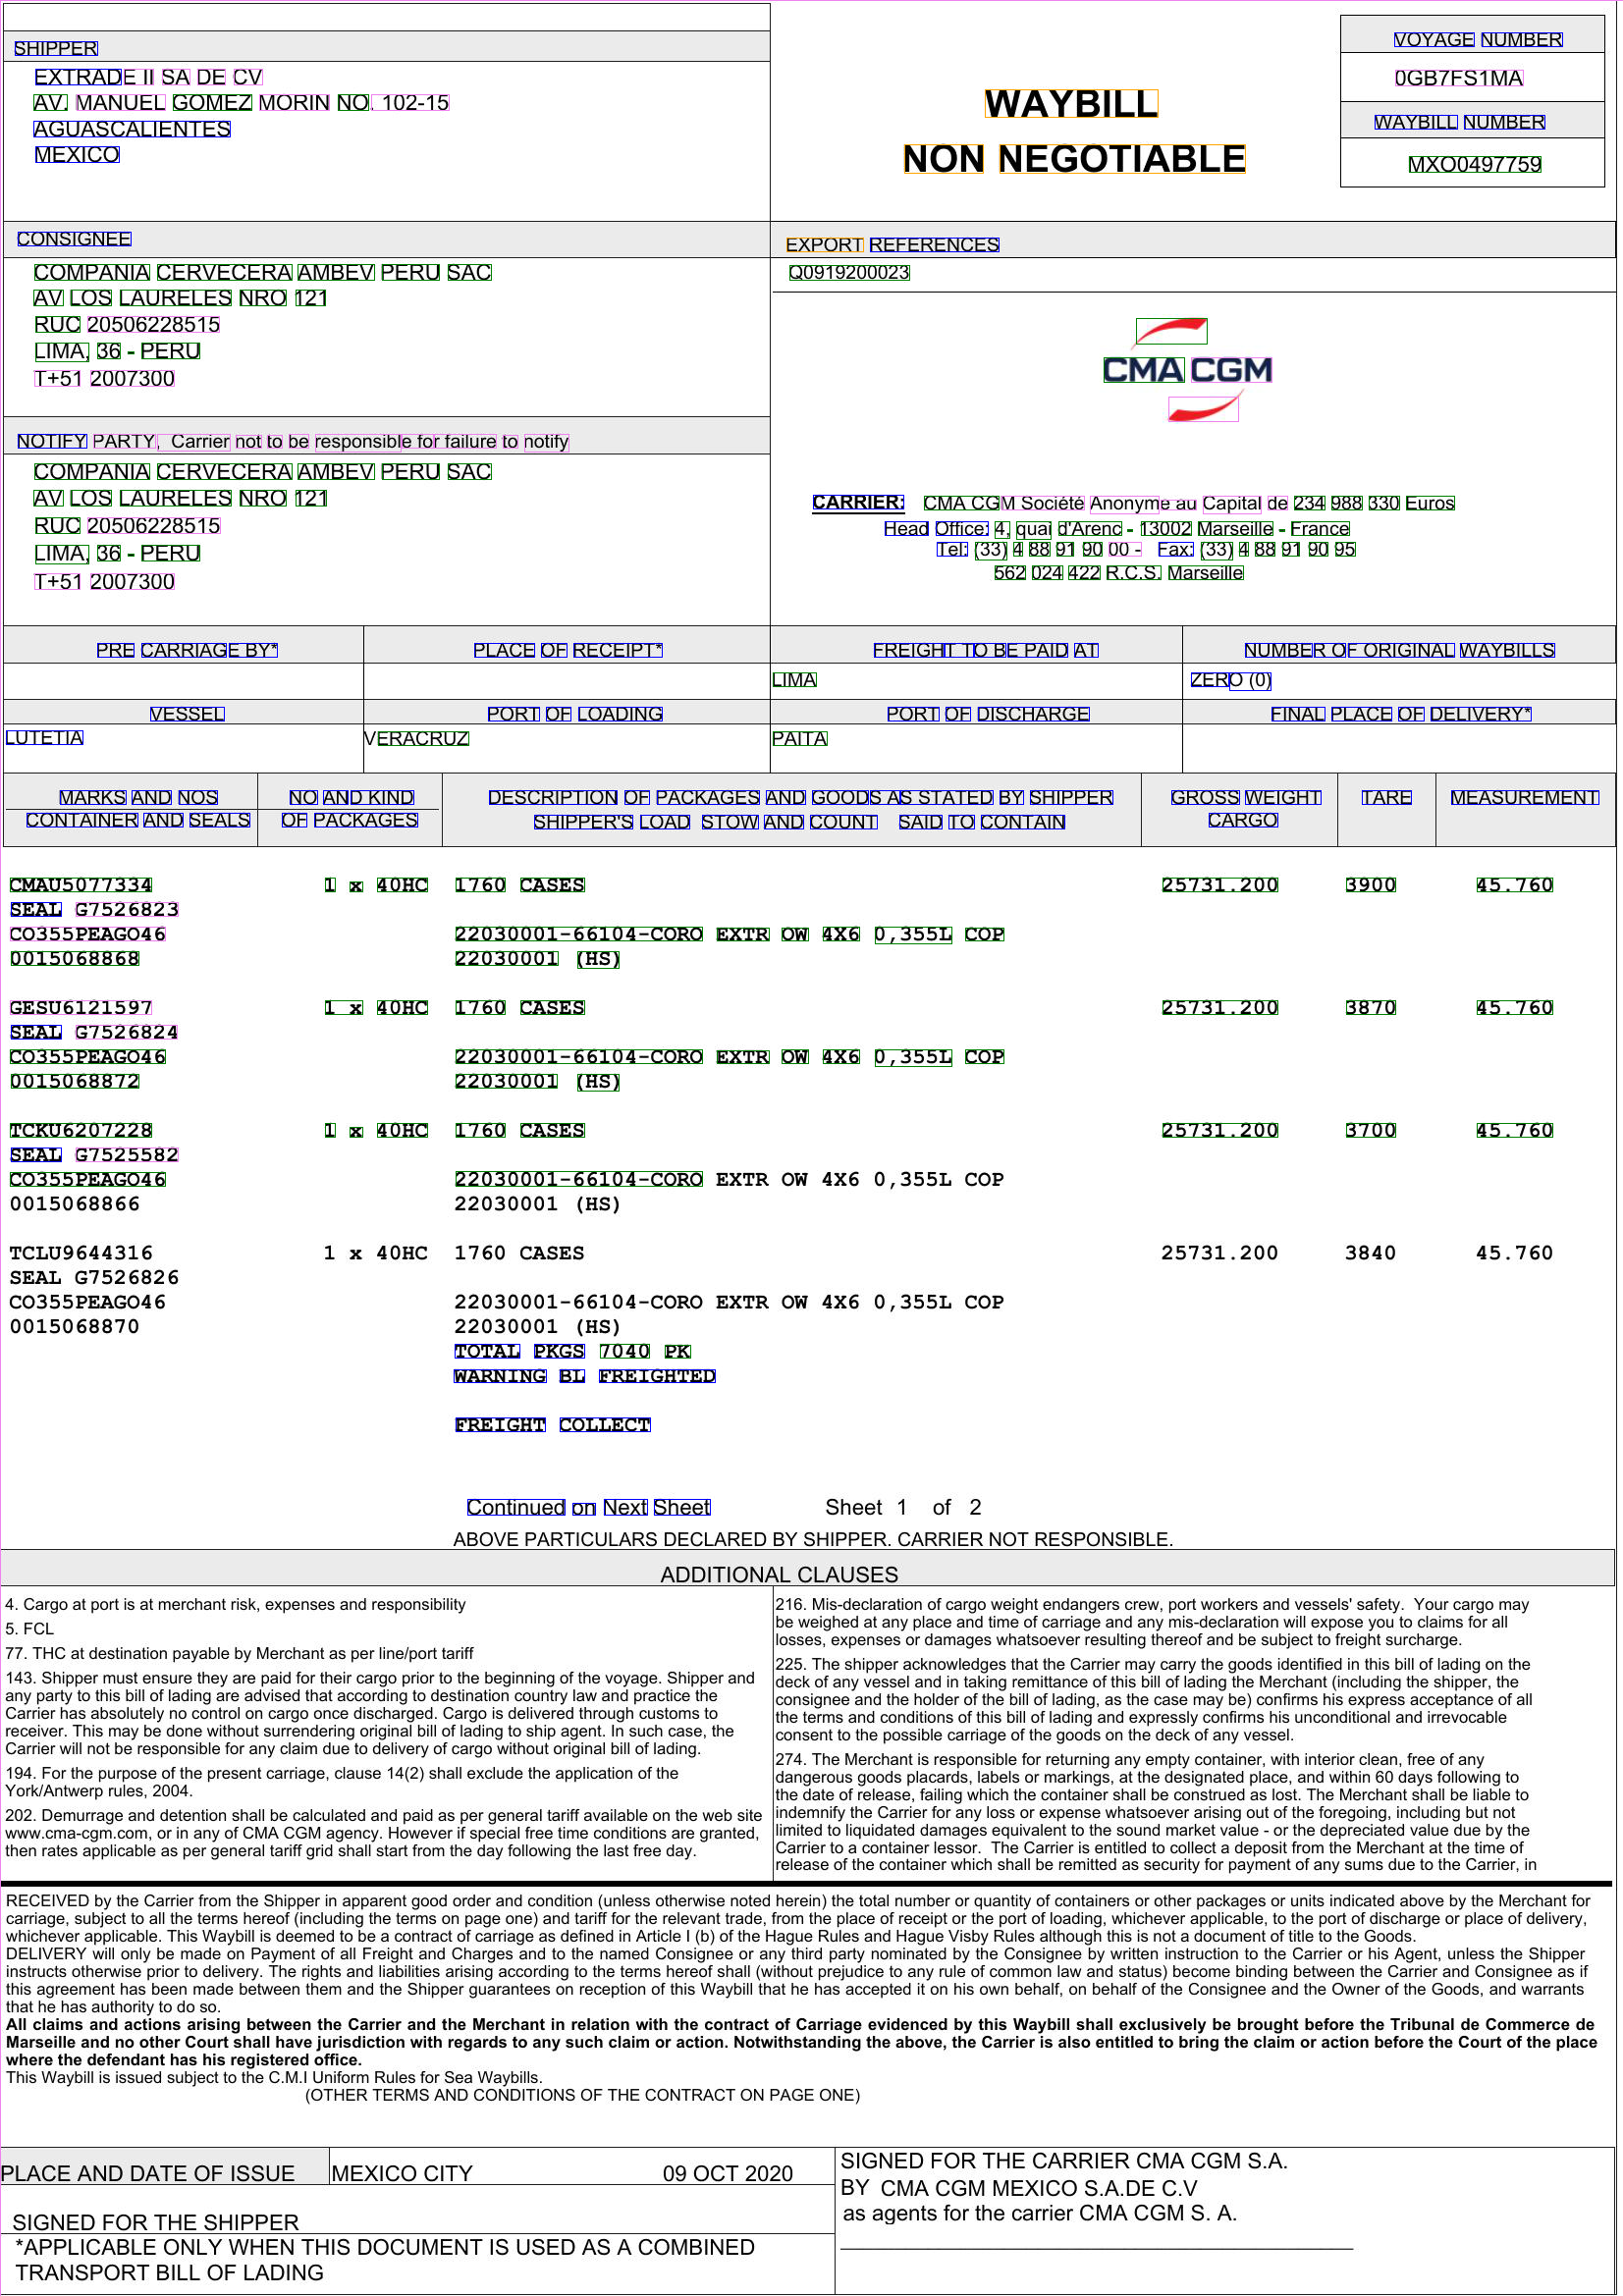

In [21]:
image = Image.open("page0.jpg") 
#image = image.convert("RGB") 

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()
#pairs ={}

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

all_words = {}

for prediction, box, text in zip(nc_word_level_predictions, nc_final_boxes,nc_box_text):

    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    box_tuple = (box[0],box[1],box[2],box[3])
    text = all_texts[box_tuple]
    t=text.encode('latin-1', 'ignore')

    center = ((box[0]+box[2])/2,(box[1]+box[3])/2)
    all_words[box_tuple] = [center,t]
    text = text_from_crop(image,(box[0],box[1]),(box[2],box[3]))
    #draw.text((box[0] + 10, box[1] - 10), text=t,fill=label2color[predicted_label], font=font)
    #cv2.putText(image,str(t),(box[0] + 10, box[1] - 10),cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 255, 255), 3)
    #draw.text((box[0] + 10, box[1] - 10), text=t, fill=label2color[predicted_label], font=font)
    #pairs[box_tuple] = predicted_label

"""
for idx,row in ocr_df.iterrows():
  d=tuple(row)
  text = d[11]
  t = text.encode('latin-1', 'ignore')
  x = d[6]+1
  y = d[7]-10
  draw.text((x, y), text=t,fill='blue', font=font)
"""

image

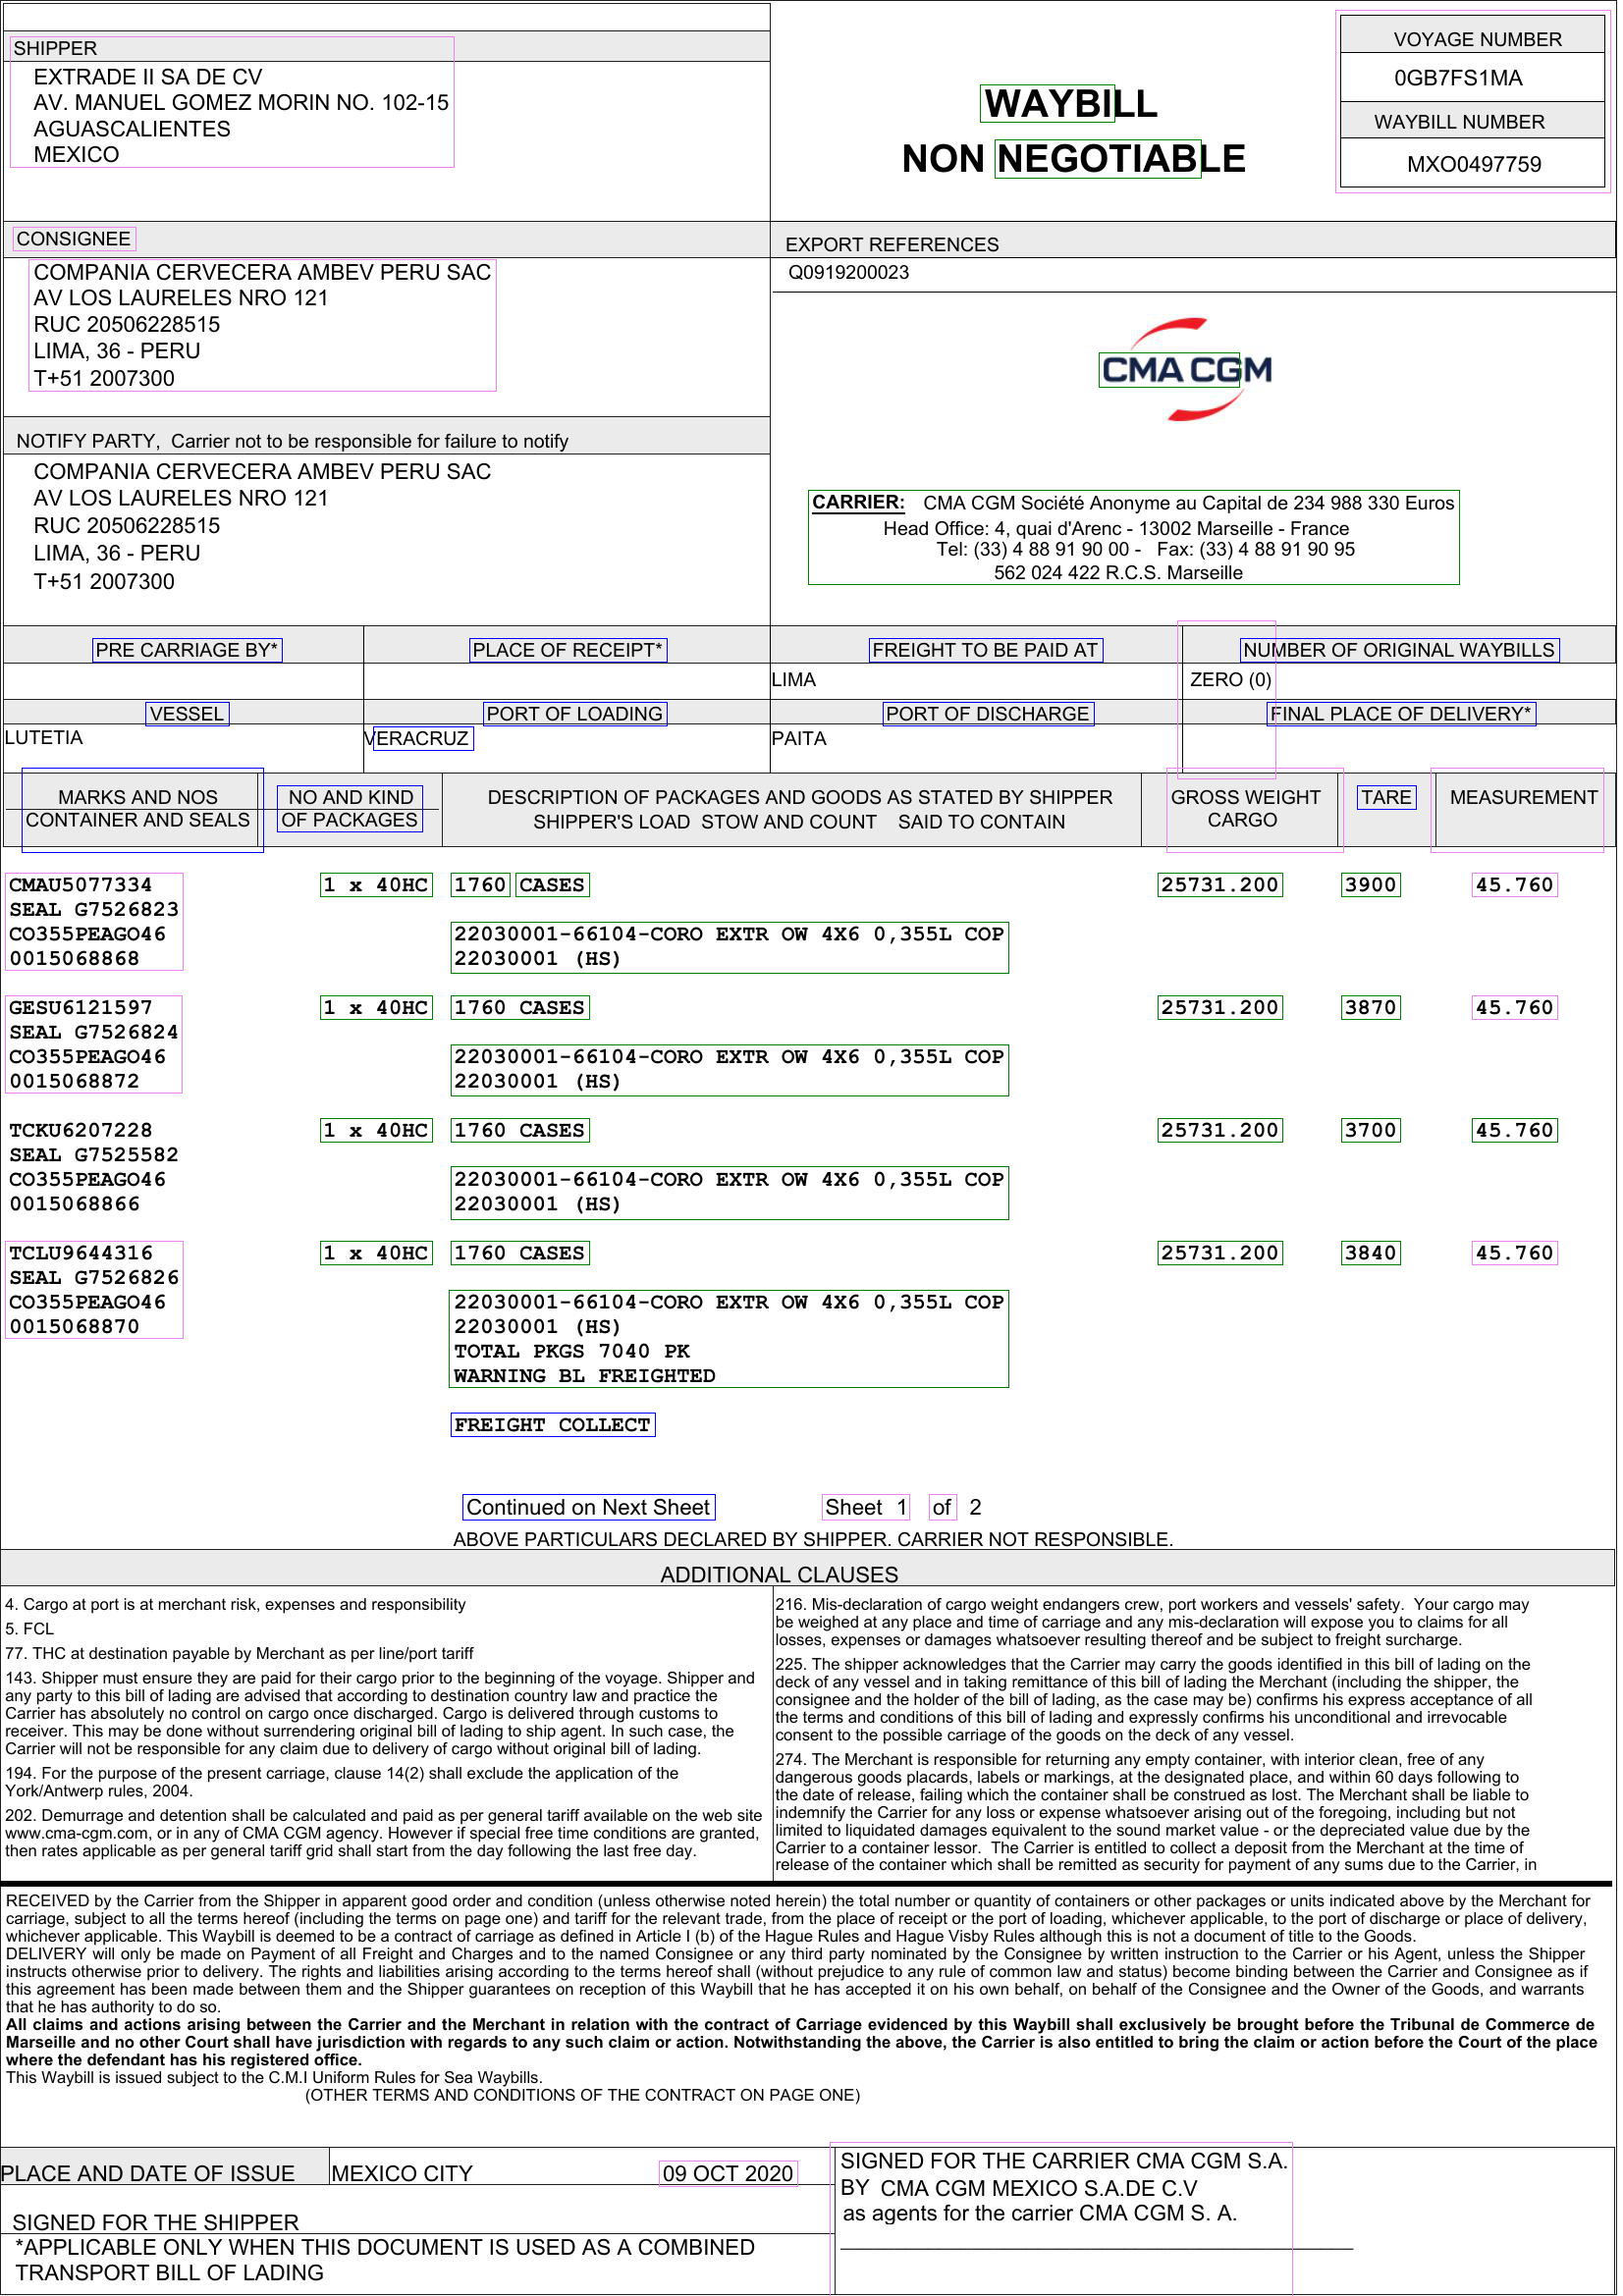

In [22]:
image = Image.open("page0.jpg")
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
fields_pairs = {}
found = 0
useful_fields = ["pre carriage by","place of receipt","freight to be paid at","number of original waybills","vessel",
                 "port of loading","port of discharge","final place of delivery"]
prev_text= ''

all_clusters = {} ## key will be the box tuple, it will store the label, the centre of the cluster and the text

for prediction, box in zip(word_level_predictions, final_boxes):

    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    box_tuple = (box[0],box[1],box[2],box[3])

    #print(predicted_label)
    #draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    #t=t.encode('latin-1', 'ignore')
    #draw.text((box[0] + 10, box[1] - 10), text=t,fill=label2color[predicted_label], font=font)
    #cv2.putText(image,str(t),(box[0] + 10, box[1] - 10),cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 255, 255), 3)
    """
    if predicted_label == 'question' and prev_tuple!=box_tuple:
      question_cluster.append(box_tuple)
    prev_tuple = box_tuple
    """
    text = text_from_crop(image,(box[0],box[1]),(box[2],box[3]),width,height).lower()
    center = ((box[0]+box[2])/2,(box[1]+box[3])/2)
    
    all_clusters[box_tuple] = [center, predicted_label, text]

    if predicted_label == 'question' or 'header' and found!=len(useful_fields):

    #if found!=len(useful_fields):
      
      box_tuple = (box[0],box[1],box[2],box[3])
      if text!=prev_text:
        #any(field in text for field in useful_fields) and
        for field in useful_fields:
          if field in text:
            found+=1
              #print(field)
              #print(text)
            fields_pairs[box_tuple] = field

      prev_text = text

"""
for idx,row in ocr_df.iterrows():
  d=tuple(row)
  text = d[11]
  t = text.encode('latin-1', 'ignore')
  x = d[6]+1
  y = d[7]-10
  draw.text((x, y), text=t,fill='blue', font=font)
"""

image

In [ ]:
all_clusters

{(5, 889, 186, 988): [(95.5, 938.5),
  'other',
  'cmau5077334\nseal g7526823\nco355peago46\n0015068868\n\x0c'],
 (5, 1014, 185, 1113): [(95.0, 1063.5),
  'other',
  'gesu6121597\nseal g7526824\nco355peago46\n0015068872\n\x0c'],
 (5, 1264, 186, 1363): [(95.5, 1313.5),
  'other',
  'tclu9644316\nseal g7526826\nco355peago46\n0015068870\n\x0c'],
 (10, 37, 462, 170): [(236.0, 103.5),
  'other',
  'shipper\nextrade ii sa de cv\nav. manuel gomez morin no. 102-15\naguascalientes\nmexico\n\x0c'],
 (13, 231, 138, 255): [(75.5, 243.0), 'other', 'consignee\n\x0c'],
 (22, 782, 268, 868): [(145.0, 825.0),
  'question',
  'marks and nos i\ncontainer and seals\n\n \n\x0c'],
 (29, 264, 505, 398): [(267.0, 331.0),
  'other',
  ' \n\ncompania cervecera ambev peru sac.\nav los laureles nro 121\n\nruc 20506228515\n\nlima, 36 - peru\n\nt+51 2007300\n\x0c'],
 (94, 650, 287, 674): [(190.5, 662.0), 'question', 'pre carriage by*\n\x0c'],
 (148, 715, 233, 739): [(190.5, 727.0), 'question', 'vessel\n\x0c'],
 (28

In [ ]:
key_value_pairs = {}

for i in fields_pairs.keys():
  flag = 0
  for a in all_texts.keys():
    #first checking the y coordinate then checking the x coordinate
    if i[3]<a[3]<i[3]+30 and i[0]-200<a[0]<i[0]+50:
      #print(i[3],a[3])
      key_value_pairs[fields_pairs[i]] = all_texts[a]
      flag=1
  if flag ==0:
    key_value_pairs[fields_pairs[i]] = "-"

In [ ]:
key_value_pairs 

{'final place of delivery': '-',
 'freight to be paid at': 'Lima',
 'number of original waybills': '(0)',
 'place of receipt': '-',
 'port of discharge': 'PAITA',
 'port of loading': 'ERACRUZ',
 'pre carriage by': '-',
 'vessel': 'LUTETIA'}

**Tablenet part**

In [ ]:
EPSILON = 1e-15

class TableNet(nn.Module):
    """TableNet."""
    def __init__(self, num_class: int, batch_norm: bool = False): 
        """Initialize TableNet.
        Args:
            num_class (int): Number of classes per point.
            batch_norm (bool): Select VGG with or without batch normalization.
        """
        super().__init__()
        self.vgg = vgg19(pretrained=True).features if not batch_norm else vgg19_bn(pretrained=True).features
        self.layers = [18, 27] if not batch_norm else [26, 39]
        self.model = nn.Sequential(nn.Conv2d(512, 512, kernel_size=1),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.8),
                                   nn.Conv2d(512, 512, kernel_size=1),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.8))
        self.table_decoder = TableDecoder(num_class)
        self.column_decoder = ColumnDecoder(num_class)

    def forward(self, x):
        """Forward pass.
        Args:
            x (tensor): Batch of images to perform forward-pass.
        Returns (Tuple[tensor, tensor]): Table, Column prediction.
        """
        results = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                results.append(x)
        x_table = self.table_decoder(x, results)
        x_column = self.column_decoder(x, results)
        return torch.sigmoid(x_table), torch.sigmoid(x_column)


class ColumnDecoder(nn.Module):
    """Column Decoder."""

    def __init__(self, num_classes: int):
        """Initialize Column Decoder.
        Args:
            num_classes (int): Number of classes per point.
        """
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.8),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.layer = nn.ConvTranspose2d(1280, num_classes, kernel_size=2, stride=2, dilation=1)

    def forward(self, x, pools):
        """Forward pass.
        Args:
            x (tensor): Batch of images to perform forward-pass.
            pools (Tuple[tensor, tensor]): The 3 and 4 pooling layer from VGG-19.
        Returns (tensor): Forward-pass result tensor.
        """
        pool_3, pool_4 = pools
        x = self.decoder(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, pool_4], dim=1)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, pool_3], dim=1)
        x = F.interpolate(x, scale_factor=2)
        x = F.interpolate(x, scale_factor=2)
        return self.layer(x)


class TableDecoder(ColumnDecoder):
    """Table Decoder."""

    def __init__(self, num_classes):
        """Initialize Table decoder.
        Args:
            num_classes (int): Number of classes per point.
        """
        super().__init__(num_classes)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
        )


In [ ]:
table_model = TableNet(1) 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
path = '/content/drive/My Drive/Abinbev/marmot_data/weights/'
table_model.load_state_dict(torch.load(path+'model_dice_loss_invoice,40,120.pkl'))  ### Change the path to where you have the weights

<All keys matched successfully>

In [ ]:
img = cv2.imread('page0.jpg')
height, width, _ = img.shape
transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((450,450))
            ])

In [ ]:
def find_col_table(img):
  tran = transform(img).unsqueeze(0) 
  out=table_model(tran)
  thresh_table = np.where(out[0]>0.99,1,0) 
  thresh_column = np.where(out[1]>0.99,1,0) 
  table=cv2.resize(thresh_table[0][0].astype(dtype='uint8'),(width,height))*255
  column=cv2.resize(thresh_column[0][0].astype(dtype='uint8'),(width,height))*255
  ret,thresh_table = cv2.threshold(table,254,255,cv2.THRESH_BINARY) 
  ret,thresh_column = cv2.threshold(column,254,255,cv2.THRESH_BINARY)
  table_contours,hierarchy = cv2.findContours(thresh_table, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  column_contours,hierarchy = cv2.findContours(thresh_column, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  table_coords = []
  for cnt in table_contours:
    x,y,w,h = cv2.boundingRect(cnt) 
    if cv2.contourArea(cnt) > 10: 
      #cv2.rectangle(table,(x,y),(x+w,y+h),(0,0,255),2)
      table_coords = (x,y,x+w,y+h)
  col_coords = []
  for cnt in column_contours:
    x,y,w,h = cv2.boundingRect(cnt) 
    if cv2.contourArea(cnt) > 10: 
      #cv2.rectangle(column,(x,y),(x+w,y+h),(0,0,255),2)
      col_coords.append([x,y,x+w,y+h])
  return table_coords, col_coords, thresh_table, thresh_column

In [ ]:
table_coord, col_coord, thresh_table, thresh_col = find_col_table(img)

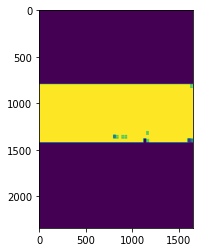

In [ ]:
plt.imshow(thresh_table)

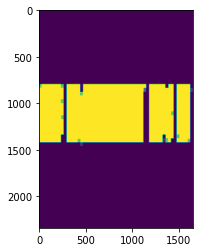

In [ ]:
plt.imshow(thresh_col)

In [ ]:
clusters_in_table = []

In [ ]:
table_coord

(0, 794, 1653, 1420)

In [ ]:
min_y = table_coord[1]
max_y = table_coord[3]

min_x = table_coord[0]
max_x = table_coord[2]

for clust_key in all_clusters.keys():
  center = all_clusters[clust_key][0]
  if min_x<center[0]<max_x and min_y<center[1]<max_y:
    clusters_in_table.append(clust_key)

In [ ]:
clusters_in_table

[(22, 782, 268, 868),
 (1188, 782, 1368, 868),
 (1457, 782, 1633, 868),
 (457, 1314, 1027, 1413),
 (282, 800, 430, 847),
 (1382, 800, 1442, 824),
 (5, 889, 186, 988),
 (326, 889, 440, 913),
 (459, 889, 519, 913),
 (525, 889, 600, 913),
 (1179, 889, 1306, 913),
 (1366, 889, 1426, 913),
 (1499, 889, 1586, 913),
 (459, 939, 1027, 991),
 (5, 1014, 185, 1113),
 (326, 1014, 440, 1038),
 (459, 1014, 600, 1038),
 (1179, 1014, 1306, 1038),
 (1366, 1014, 1426, 1038),
 (1499, 1014, 1586, 1038),
 (459, 1064, 1027, 1116),
 (326, 1139, 440, 1163),
 (459, 1139, 600, 1163),
 (1179, 1139, 1306, 1163),
 (1366, 1139, 1426, 1163),
 (1499, 1139, 1586, 1163),
 (459, 1188, 1027, 1242),
 (5, 1264, 186, 1363),
 (326, 1264, 440, 1288),
 (459, 1264, 600, 1288),
 (1179, 1264, 1306, 1288),
 (1366, 1264, 1426, 1288),
 (1499, 1264, 1586, 1288)]

In [ ]:
clust_with_table = img 
for i in clusters_in_table: 
  cv2.rectangle(clust_with_table,(i[0],i[1]),(i[2],i[3]),(0,0,255),2) 

In [ ]:
cv2.imwrite('clust_in_table.bmp',clust_with_table) 

True

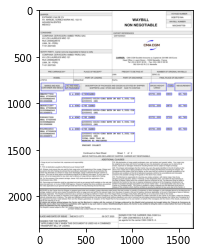

In [ ]:
plt.imshow(clust_with_table) 

In [ ]:
image

In [ ]:
for clust in clusters_in_table:
  if "no and kind" in all_clusters[clust][2]:
    print(all_clusters[clust][2])

no and kind
of packages



In [ ]:
clusters_in_table[0] 

(22, 782, 268, 868)

In [ ]:
all_clusters[clusters_in_table[0]] 

[(145.0, 825.0), 'question', 'marks and nos i\ncontainer and seals\n\n \n\x0c']